# trained model prediction 
**this notebook focuses on the trained model prediction.**


#### import packages


In [1]:
import torch
# import sys
# sys.path.insert(0, sys.path[0]+"/../src")
import os

desired_path = "../src/"
os.chdir(desired_path)

from models import MultiTaskModel   
import constants as _constants_
import  matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from dataset import TestingCollator, TestingDataset
from evaluate import  Evaluator
import pdb, os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from losses import LG_CLIP_LOSS
import constants
from dataset import ImageTextContrastiveDataset, ImageTextContrastiveCollator, TestingCollator, TestingDataset
from models import MultiTaskModel
from train import Trainer
from evaluate import  Evaluator
import argparse
import traceback
import constants as _constants_
import logging
import os
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

/home_data/home/v-liudsh/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utility function

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
   
def weight_parser(items=None):
  uncertain_based_weight = items[-3:]
  task_balance = items[-2:]
  if "task" in task_balance and "balance" in task_balance:
    for i in range(len(task_balance)):
      items.pop()
    task_balance = "_".join(task_balance)
    items.append(task_balance)
    return items
  elif "uncertain" in uncertain_based_weight and "based" in uncertain_based_weight and "weight" in uncertain_based_weight:
    for i in range(len(uncertain_based_weight)):
      items.pop()
    uncertain_based_weight = "_".join(uncertain_based_weight)
    items.append(uncertain_based_weight)
    return items
  return items


def load_model(path = None, backbone = "biomedclip", visual_branch_only = False, backbone_v = None, 
               high_order="NA", no_orthogonize = False, no_contrastive = False ):
  if path == None:
    raise ValueError("you should specify the path of model")
  print( backbone , visual_branch_only , backbone_v , 
               high_order, no_orthogonize , no_contrastive )
  model = MultiTaskModel(nntype = backbone, visual_branch_only=visual_branch_only,backbone_v = backbone_v,high_order=high_order, 
                         no_orthogonize = no_orthogonize, no_contrastive=no_contrastive, )
  # print(model)
  if device == "cpu":
    model.load_state_dict(torch.load(path,  map_location=torch.device('cpu')))
  else:
    model.load_state_dict(torch.load(path))
  model.eval()
  return model


def model_infer_eval(model = None, backbone_type = None, dump_path = None):
  if model is None:
    raise ValueError("you should specify the model before inference")
    # build evaluator
  if device == "cuda":
    model.cuda()
  # config_dict = parse_model_path(model)
  
  val_data = TestingDataset(backbone_type=backbone_type)
  val_collate_fn = TestingCollator()
  eval_dataloader = DataLoader(val_data,
      batch_size=256,
      collate_fn=val_collate_fn,
      shuffle=False,
      pin_memory=True,
      num_workers = 2,
      )
  _evaluator_ = Evaluator(
      FG_model_cls = model,
      eval_dataloader = eval_dataloader,
      mode='multiclass')
    
  dump = {
    "prediction":"./output/dump/prediction/",
    "label":"./output/dump/labels/",
    "dump_path":"./output/dump/predict_with_default_name/"
  }
  if dump_path is not None:
    dump["dump_path"] = dump_path
  scores = _evaluator_.evaluate(dump = dump)
  print(f'\n\033[31m######### Eval #########\033[0m')
  for key in scores.keys():
      if key in ['acc','auc', 'auc/mse', ]:
        print('{}: {:.4f}'.format(key, scores[key]))
      if key == "auc_dict":
        for i,j in scores[key].items():
          print(i, j)
        av_auc = get_average_auc_among_disease(scores[key], indicator = "positive")

          
def parse_model_path(path:str)->dict:
  split = ""
  if "/" in path:
    split = "/"  
  parser_material = path.split(split)
  parser_material = parser_material[-2]
  config = parser_material.split("_")
  config = weight_parser(config)
  config_items = ["backbone", "backbone_v", "visual_branch_only", "learnable_weight", "high_order", "no_orthogonize", "no_contrastive", "weight_strategy"]
  config_dict=  {}
  print(config_items)
  print(config)
  assert len(config) == len(config_items)
  converter = {"None": None, "False": False, "True": True}
  for i, j in zip(config_items, config):
    if j in converter:
      j = converter[j]
    config_dict[i] = j
    print(f"{constants.RED}{i}{constants.RESET}: {j}")
  return config_dict

def plot_heat_map(matrix, title = None):
  # 计算矩阵中行向量之间的余弦相似度
  cos_sim = cosine_similarity(matrix)

  # 绘制热度图
  plt.figure(figsize=(8, 6))
  plt.imshow(cos_sim, cmap='coolwarm', interpolation='nearest')
  plt.colorbar(label='Cosine Similarity')  # 添加颜色条，并标记单位
  for i in range(cos_sim.shape[0]):
      for j in range(cos_sim.shape[1]):
          plt.text(j, i, f'{cos_sim[i, j]:.2f}', ha='center', va='center', color='black')  # 在热力图上输出数值
  if title is None: 
    plt.title('Cosine Similarity Heatmap')
  else:
    plt.title(title)
  plt.xlabel('Row Index')
  plt.ylabel('Row Index')
  plt.show()

def plot_heat_map_dual(matrix1, matrix2, title1=None, title2=None):
  cos_sim1 = cosine_similarity(matrix1)

  # 计算矩阵2中行向量之间的余弦相似度
  cos_sim2 = cosine_similarity(matrix2)

  # 创建画布和子图
  fig, axes = plt.subplots(1, 2, figsize=(18, 6))

  # 绘制子图1
  im1 = axes[0].imshow(cos_sim1, cmap='coolwarm', interpolation='nearest')
  axes[0].set_title(title1)

  # # 在热度图上添加文本标签
  # for i in range(cos_sim1.shape[0]):
  #     for j in range(cos_sim1.shape[1]):
  #         axes[0].text(j, i, f'{cos_sim1[i, j]:.2f}', ha='center', va='center', color='black')

  # 绘制子图2
  im2 = axes[1].imshow(cos_sim2, cmap='coolwarm', interpolation='nearest')
  axes[1].set_title(title2)

  # 在热度图上添加文本标签
  # for i in range(cos_sim2.shape[0]):
  #     for j in range(cos_sim2.shape[1]):
  #         axes[1].text(j, i, f'{cos_sim2[i, j]:.2f}', ha='center', va='center', color='black')

  # 显示图例
  fig.colorbar(im1, ax=axes[0])
  fig.colorbar(im2, ax=axes[1])

  plt.show()

# parse_model_path("/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/biovil-t_None_False_False_binary_False_False_NA/pytorch_model.bin")

----
<p align=center>BioVil-T</p>

In [11]:
model_path = "/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/src/output/biovil-t_None_False_False_binary_False_False_NA/final_pytorch_model.bin"

In [97]:
config_dict = parse_model_path(model_path)
config_dict.pop("learnable_weight")
config_dict.pop("weight_strategy")
config_dict["path"] = model_path
model = load_model(**config_dict)

backbone: biovil-t
backbone_v: None
visual_branch_only: False
learnable_weight: False
high_order: binary
no_orthogonize: False
no_contrastive: False
weight_strategy: NA
in current image branch, the vis backbone for vis embedding is: biovil-t
in current Text branch, the text backbone for text embedding is: biovil-t


In [101]:
resutls  = model.Contrastive_Model.encode_text(["/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/data/prompts_tensors/basic/biovil_t.pt","/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/data/prompts_tensors/basic/biovil_t.pt"])

torch.Size([2, 14, 128])


In [99]:
txt_embedding = resutls[0].squeeze()
txt_embedding.shape

origin_txt_embedding = torch.load("/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/data/prompts_tensors/basic/biovil_t.pt")

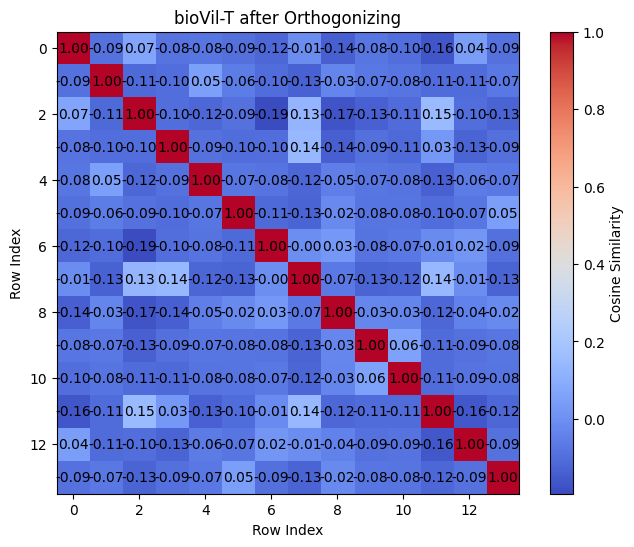

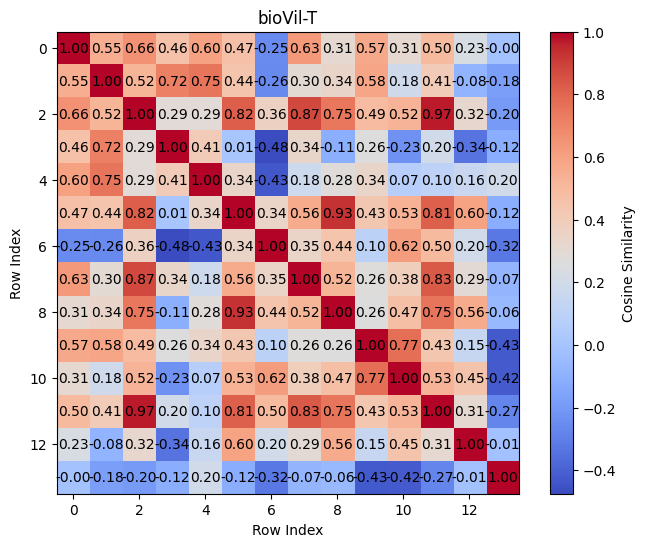

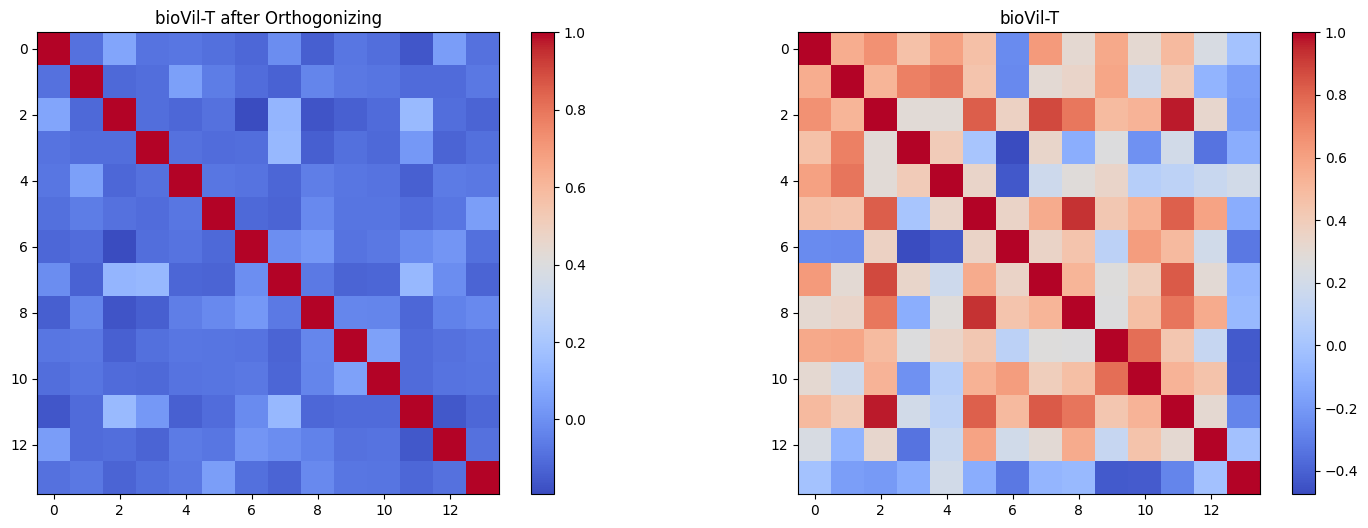

In [100]:
matrix = txt_embedding.detach().numpy()
plot_heat_map(matrix, "bioVil-T after Orthogonizing")
matrix_1 = origin_txt_embedding.detach().numpy()
plot_heat_map(matrix_1, "bioVil-T")
plot_heat_map_dual(matrix, matrix_1, "bioVil-T after Orthogonizing", "bioVil-T")

---
<p align=center>BiomedCLIP</p>

In [15]:
model_path = "/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning_old/output/biomedclip_None_False_False_binary_True_True_task_balance/final_pytorch_model.bin"
config_dict = parse_model_path(model_path)
config_dict.pop("learnable_weight")
config_dict.pop("weight_strategy")
config_dict["path"] = model_path
model = load_model(**config_dict)
prompt_tensor = "/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/data/prompts_tensors/basic/biomedclip.pt"
resutls  = model.Contrastive_Model.encode_text([prompt_tensor, prompt_tensor])
txt_embedding = resutls[0].squeeze()
origin_txt_embedding = torch.load(prompt_tensor)
matrix = txt_embedding.detach().numpy()
plot_heat_map(matrix, "biomedCLIP after Orthogonizing")
matrix_1 = origin_txt_embedding.detach().numpy()
plot_heat_map(matrix_1, "biomedCLIP")
plot_heat_map_dual(matrix, matrix_1, "biomedCLIP after Orthogonizing", "biomedCLIP")

['backbone', 'backbone_v', 'visual_branch_only', 'learnable_weight', 'high_order', 'no_orthogonize', 'no_contrastive', 'weight_strategy']
['biomedclip', 'None', 'False', 'False', 'binary', 'True', 'True', 'task_balance']
backbone: biomedclip
backbone_v: None
visual_branch_only: False
learnable_weight: False
high_order: binary
no_orthogonize: True
no_contrastive: True
weight_strategy: task_balance
biomedclip False None binary True True
in current image branch, the vis backbone for vis embedding is: biomedclip
in current Text branch, the text backbone for text embedding is: biomedclip
MultiTaskModel(
  (Contrastive_Model): LGCLIP(
    (vision_model): ImgBranch(
      (projection_head): Linear(in_features=512, out_features=512, bias=False)
      (clip_model): CustomTextCLIP(
        (visual): TimmModel(
          (trunk): VisionTransformer(
            (patch_embed): PatchEmbed(
              (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
              (norm): Identity()
  

RuntimeError: Error(s) in loading state_dict for MultiTaskModel:
	Unexpected key(s) in state_dict: "Contrastive_Model.text_model.clip_model.logit_scale", "Contrastive_Model.text_model.clip_model.visual.trunk.cls_token", "Contrastive_Model.text_model.clip_model.visual.trunk.pos_embed", "Contrastive_Model.text_model.clip_model.visual.trunk.patch_embed.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.patch_embed.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.0.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.1.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.2.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.3.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.4.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.5.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.6.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.7.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.8.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.9.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.10.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.norm1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.norm1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.attn.qkv.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.attn.qkv.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.attn.proj.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.attn.proj.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.norm2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.norm2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.mlp.fc1.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.mlp.fc1.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.mlp.fc2.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.blocks.11.mlp.fc2.bias", "Contrastive_Model.text_model.clip_model.visual.trunk.norm.weight", "Contrastive_Model.text_model.clip_model.visual.trunk.norm.bias", "Contrastive_Model.text_model.clip_model.visual.head.proj.weight", "Contrastive_Model.text_model.clip_model.text.transformer.embeddings.word_embeddings.weight", "Contrastive_Model.text_model.clip_model.text.transformer.embeddings.position_embeddings.weight", "Contrastive_Model.text_model.clip_model.text.transformer.embeddings.token_type_embeddings.weight", "Contrastive_Model.text_model.clip_model.text.transformer.embeddings.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.embeddings.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.0.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.1.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.2.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.3.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.4.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.5.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.6.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.7.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.8.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.9.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.10.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.self.query.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.self.query.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.self.key.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.self.key.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.self.value.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.self.value.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.attention.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.intermediate.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.intermediate.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.output.dense.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.output.dense.bias", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.output.LayerNorm.weight", "Contrastive_Model.text_model.clip_model.text.transformer.encoder.layer.11.output.LayerNorm.bias", "Contrastive_Model.text_model.clip_model.text.proj.0.weight", "Contrastive_Model.text_model.clip_model.text.proj.2.weight". 

---
<p align=center>CLIP</p>

In [7]:
model_path = "/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning_old/output/clip_None_False_False_binary_True_True_task-balance/pytorch_model.bin"
config_dict = parse_model_path(model_path)
config_dict.pop("learnable_weight")
config_dict.pop("weight_strategy")
config_dict["path"] = model_path
model = load_model(**config_dict)
prompt_tensor = "/home_data/home/v-liudsh/coding/constrastive_P/diagnosisP/exchange/Fine-Grained_Features_Alignment_via_Constrastive_Learning/data/prompts_tensors/basic/clip.pt"
resutls  = model.Contrastive_Model.encode_text([prompt_tensor, prompt_tensor])
txt_embedding = resutls[0].squeeze()
txt_embedding.shape

origin_txt_embedding = torch.load(prompt_tensor)
matrix = txt_embedding.detach().numpy()
plot_heat_map(matrix, "CLIP after Orthogonizing")
matrix_1 = origin_txt_embedding.detach().numpy()
plot_heat_map(matrix_1, "CLIP")
plot_heat_map_dual(matrix, matrix_1, "CLIP after Orthogonizing", "CLIP")

['backbone', 'backbone_v', 'visual_branch_only', 'learnable_weight', 'high_order', 'no_orthogonize', 'no_contrastive', 'weight_strategy']
['clip', 'None', 'False', 'False', 'binary', 'True', 'True', 'task-balance']
backbone: clip
backbone_v: None
visual_branch_only: False
learnable_weight: False
high_order: binary
no_orthogonize: True
no_contrastive: True
weight_strategy: task-balance
in current image branch, the vis backbone for vis embedding is: clip
in current Text branch, the text backbone for text embedding is: clip


RuntimeError: Error(s) in loading state_dict for MultiTaskModel:
	Unexpected key(s) in state_dict: "Contrastive_Model.text_model.clip_model.positional_embedding", "Contrastive_Model.text_model.clip_model.text_projection", "Contrastive_Model.text_model.clip_model.logit_scale", "Contrastive_Model.text_model.clip_model.visual.class_embedding", "Contrastive_Model.text_model.clip_model.visual.positional_embedding", "Contrastive_Model.text_model.clip_model.visual.proj", "Contrastive_Model.text_model.clip_model.visual.conv1.weight", "Contrastive_Model.text_model.clip_model.visual.ln_pre.weight", "Contrastive_Model.text_model.clip_model.visual.ln_pre.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.0.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.1.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.2.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.3.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.4.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.5.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.6.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.7.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.8.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.9.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.10.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.ln_1.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.ln_1.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.ln_2.weight", "Contrastive_Model.text_model.clip_model.visual.transformer.resblocks.11.ln_2.bias", "Contrastive_Model.text_model.clip_model.visual.ln_post.weight", "Contrastive_Model.text_model.clip_model.visual.ln_post.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.0.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.1.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.2.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.3.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.4.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.5.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.6.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.7.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.8.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.9.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.10.ln_2.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.attn.in_proj_weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.attn.in_proj_bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.attn.out_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.attn.out_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.ln_1.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.ln_1.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.mlp.c_fc.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.mlp.c_fc.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.mlp.c_proj.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.mlp.c_proj.bias", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.ln_2.weight", "Contrastive_Model.text_model.clip_model.transformer.resblocks.11.ln_2.bias", "Contrastive_Model.text_model.clip_model.token_embedding.weight", "Contrastive_Model.text_model.clip_model.ln_final.weight", "Contrastive_Model.text_model.clip_model.ln_final.bias". 